# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *

In [3]:
import urllib.request
from zipfile import ZipFile

import contextily as ctx
import fiona
import osmnx
import shapely
import yaml

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
P = U.Project('..')

In [6]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/08/31 09:13:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/31 09:13:33 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/08/31 09:13:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/08/31 09:13:34 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Controls

In [7]:
# spatial scales of the maps
SCALES = ['BG', 'County', 'Tract']

In [8]:
# travel modes considered
MODES = ['Bicycling', 'Driving', 'Transit', 'Walking']

In [9]:
# travel time thresholds (in minutes)
TRAVEL_TIMES = [15, 30, 45, 60]

# Regional boundaries

## Download data
Note that the TIGER/LINE boundaries and ACS data of the subdivisions of Indiana at different scales were already downloaded in [../../spr_4608/code/1_Geometry_ACS.ipynb](../../spr_4608/code/1_Geometry_ACS.ipynb), but they were for the year 2020 (I think). The files were then directly copied from `$MK/spr_4608/data/geometry` to `$MK/spr_4711/data/acs`.

However, since the UMN access data used the 2010 definitions, they are downloaded explicitly from the Census website.

In [10]:
def download_tiger_boundary(scale, year=2010, state='Indiana', save=True, overwrite=False):
    scale = scale.lower()
    assert scale in ['tabblock', 'bg', 'taz', 'tract', 'county', 'cbsa']
    outfile = P.data / f'boundary/{scale}.parquet'
    if outfile.exists() and not overwrite:
        return
    print('Downloading zones at scale:', scale)
    fips = mk.geo.US_STATES_FIPS[state.upper()]
    year_label = str(year % 2000)
    url = (f'https://www2.census.gov/geo/pvs/tiger{year}st/{fips}_{state}/'
           f'{fips}/tl_{year}_{fips}_{scale}{year_label}.zip')
    if scale == 'taz': url = url.replace('tl_2010', 'tl_2011')
    zipfile = P.data / f'tiger_boundary_{scale}.zip'
    urllib.request.urlretrieve(url, zipfile)
    df = gpd.read_file(zipfile).to_crs(CRS_DEG)
    df = df.rename(columns=lambda x: x.lower().replace(year_label, ''))
    if 'nameslad' in df.columns:
        df = (df.drop(columns='name', errors='ignore')
              .rename(columns={'namelsad': 'name'}))
    cols = ['geoid','name','aland','awater','geometry']
    if 'name' not in df.columns: cols.pop(1)
    df = df[cols]
    if save: df.to_parquet(U.mkfile(outfile))
    zipfile.unlink()
    return df

# download_tiger_boundary('County')

In [11]:
# t=2:14
for scale in tqdm(['County', 'Tract', 'BG', 'TabBlock', 'CBSA', 'TAZ']):
    download_tiger_boundary(scale)

  0%|          | 0/6 [00:00<?, ?it/s]

## Combine scales

In [12]:
bound = pd.concat([
    gpd.read_parquet(P.data / f'boundary/{scale.lower()}.parquet')
    .assign(scale=scale) for scale in SCALES
]).astype({'geoid': 'category'}).reset_index(drop=True).set_crs(CRS_DEG).disp()

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: EPSG:4326


,geoid,aland,awater,geometry,scale,name
,<category>,<int64>,<int64>,<geometry>,<object>,<object>
0,181379685003,2566010,39626,"POLYGON ((-85.20815 39.304011, -85.208134 39.3...",BG,NaN


In [13]:
# bound.to_parquet(P.data / 'export/boundary.parquet')

# AAA
**Access Across America (AAA)** from [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

## Download data

### [Auto (2018)](https://conservancy.umn.edu/handle/11299/211408)
Data not available for Indiana 😭

### [Transit (2019)](https://conservancy.umn.edu/handle/11299/218072)

### [Bike (2019)](https://conservancy.umn.edu/handle/11299/218194)

### [Walk (2014)](https://conservancy.umn.edu/handle/11299/173991)
Only available for Indianapolis region

## Extract layers

In [14]:
def get_aaa_layers(mode, year=2017):
    mode = mode.lower()
    assert mode in ['bike', 'transit']
    fpath = P.data / f'aaa/{mode}/indiana.gpkg'
    year = str(year % 2000)
    for layer in tqdm(fiona.listlayers(fpath)):
        if not layer.startswith(mode[:2] + '_'): continue
        tt = int(layer.split('_')[1])
        df = gpd.read_file(fpath, layer=layer).astype({'blockid': int})
        df = df.set_index('blockid').rename_axis('geoid')
        df = df.filter(like=f'_{year}').astype(np.int32)
        df = df.rename(columns=lambda x: x.replace(f'_{year}', ''))
        df.to_parquet(P.data / f'aaa/{mode}/{tt:02}_min.parquet')

In [15]:
# %time x = get_aaa_layers('bike'); x # t=8:32

In [16]:
# get_aaa_layers('transit') # t=9:16

## Get useful info
**[Columns documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

Chosen variables described in a YAML file: `{P.data}/aaa/lehd_variables.yml`.

Description of LODES columns: https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.4.pdf

In [17]:
with open(P.data / 'aaa/lehd_variables.yml', 'rb') as f:
    lehd_cat_vars = yaml.safe_load(f)

In [18]:
def get_aaa_tables(scale, mode, tt_thresh, cat_vars=lehd_cat_vars):
    fpath = P.data / f'aaa/{mode.lower()}/{tt_thresh:02}_min.parquet'
    df = pd.read_parquet(fpath)
    digits = {'Block': 15, 'BG': 12, 'Tract': 11, 'County': 5}[scale]
    df.index = df.index.astype(str).str.slice(0, digits).rename('geoid')
    df = df.groupby('geoid').sum().astype(np.int32)
    res = []
    for is_rac, prefix in [(False, 'w_'), (True, 'r_')]:
        res.append(df.filter(like=prefix).reset_index()
                   .rename(columns=lambda x: x.replace(prefix, ''))
                   .assign(**{'is_rac': is_rac}))
    df = (pd.concat(res).set_index(['is_rac', 'geoid'])
          .fillna(0).astype(np.int32))
    res = []
    for cat, codes2vars in cat_vars.items():
        d = df[codes2vars.keys()].rename(columns=codes2vars).reset_index()
        d = d.melt(['is_rac', 'geoid'], var_name='subcategory', value_name='num_jobs')
        d['category'] = cat
        res.append(d)
    df = (pd.concat(res).reset_index(drop=True)
          [['is_rac', 'category', 'subcategory', 'geoid', 'num_jobs']])
    return df

# %time x = get_aaa_tables('Tract', 'Transit', 30); x

## Prepare a single file for export

In [19]:
def get_aaa_overall(scales=SCALES, modes=('Bike', 'Transit'), travel_times=TRAVEL_TIMES,
                    save=True, overwrite=False):
    outfile = P.data / 'export/aaa.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    res = []
    for scale in tqdm(scales):
        for mode in modes:
            for tt in travel_times:
                df = get_aaa_tables(scale, mode, tt)
                mode2 = 'Bicycling' if mode == 'Bike' else mode
                df = df.assign(mode=mode2, scale=scale, tt_thresh=tt)
                res.append(df)
    df = pd.concat(res).reset_index(drop=True)
    df = df.astype({x: 'category' for x in [
        'category', 'subcategory', 'geoid', 'mode', 'scale', 'tt_thresh']})
    df = df[['scale', 'mode', 'tt_thresh', 'is_rac',
             'category', 'subcategory', 'geoid', 'num_jobs']]
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

%time aaa = get_aaa_overall(overwrite=0).disp() # t=1:51

+-----+---------+---------+------+--------+-----------+------------+--------+
|scale|     mode|tt_thresh|is_rac|category|subcategory|       geoid|num_jobs|
+-----+---------+---------+------+--------+-----------+------------+--------+
|   BG|Bicycling|       15| false| Overall|      Total|180010301001|     154|
+-----+---------+---------+------+--------+-----------+------------+--------+
only showing top 1 row

CPU times: user 6.7 ms, sys: 33.7 ms, total: 40.4 ms
Wall time: 6.14 s


# EPA EJ Screening Tool

## Download data

Download links taken from https://gaftp.epa.gov/EJSCREEN/2022 (directed from the [Download page](https://www.epa.gov/ejscreen/download-ejscreen-data)).

In [20]:
url_tract = 'https://gaftp.epa.gov/EJScreen/2023/EJSCREEN_2023_Tracts_StatePct_with_AS_CNMI_GU_VI.csv.zip'
url_bg = 'https://gaftp.epa.gov/EJScreen/2023/EJSCREEN_2023_BG_StatePct_with_AS_CNMI_GU_VI.csv.zip'

In [21]:
def download_epa_ejs(url, fname, unzip=False, overwrite=False):
    root = U.mkdir(P.data / 'ejscreen')
    zipped = root / f'{fname}.csv.zip'
    csv = root / f'{fname}.csv'
    if csv.exists() and not overwrite:
        return
    urllib.request.urlretrieve(url, zipped)
    if unzip:
        fname = url.split('/')[-1].replace('.zip', '')
        with ZipFile(zipped, 'r') as f:
            f.extract(fname, path=root)
        (root / fname).rename(csv)
        zipped.unlink()
    
# %time download_epa_ejs(url_tract, 'tract2023', unzip=1) # t=0:06
# %time download_epa_ejs(url_bg, 'bg2023', unzip=1) # t=0:23

## Clean data
The list of all columns in the EJS data files was downloaded from the server ([link to Excel file](https://gaftp.epa.gov/EJScreen/2023/EJSCREEN_2023_BG_Columns.xlsx)). The columns relevant to the transport equity dashboard were manually identified from this file and stored in `{P.data}/ejscreen/variables.csv`.

In [22]:
ejs_vars = pd.read_csv(P.data / 'ejscreen/variables.csv').disp(3)

51 rows x 5 cols; Memory: 0.0 MiB


,is_ses,is_derived,is_pctile,code,variable
,<bool>,<bool>,<bool>,<object>,<object>
0,True,False,False,ACSTOTPOP,Total: Population
1,True,False,False,ACSIPOVBAS,Total: Eligible poverty status
2,True,False,False,ACSEDUCBAS,Total: 25 years and over


In [23]:
def clean_ejs_data(cols=ejs_vars, year=2023, scales=['Tract', 'BG'], state='Indiana',
                   save=True, overwrite=False):
    outpath = P.data / f'export/ejs.parquet'
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    res = []
    for scale in scales:
        file = P.data / f'ejscreen/{scale.lower()}{year}.csv'
        df = pd.read_csv(file, usecols=['ID', 'STATE_NAME'] + cols['code'].tolist())
        df = df.query(f'STATE_NAME == "{state}"').drop(columns='STATE_NAME')
        df = df.melt('ID', var_name='code').merge(cols, on='code').drop(columns='code')
        df = df.rename(columns={'ID': 'geoid'}).astype({'geoid': str, 'value': float})
        res.append(df.assign(scale=scale))
    df = pd.concat(res).reset_index(drop=True)
    df = df.astype({x: 'category' for x in ['geoid', 'variable', 'scale']})
    df = df['scale is_ses is_derived is_pctile variable geoid value'.split()]
    if save:
        df.to_parquet(U.mkfile(outpath))
    return df

ejs = clean_ejs_data(overwrite=0).disp() # t=0:33

+-----+------+----------+---------+-----------------+-----------+------+
|scale|is_ses|is_derived|is_pctile|         variable|      geoid| value|
+-----+------+----------+---------+-----------------+-----------+------+
|Tract|  true|     false|    false|Total: Population|18001030100|4826.0|
+-----+------+----------+---------+-----------------+-----------+------+
only showing top 1 row



# POIs

In [24]:
with open(P.data / 'pois/poi_categories.yml', 'rb') as f:
    poi_categories = yaml.safe_load(f)

poi_classes = []
for source, data in poi_categories.items():
    for cat, fclasses in data.items():
        for fclass in fclasses:
            poi_classes.append((source, cat, fclass))
poi_classes = Pdf(poi_classes, columns=['source', 'category', 'fclass']).disp()

64 rows x 3 cols; Memory: 0.0 MiB


,source,category,fclass
,<object>,<object>,<object>
0,SafeGraph,Education,Elementary and Secondary Schools


## OSM

In [29]:
def get_osm_pois(geocode, categories: Pdf, save=True, overwrite=False):
    outfile = P.data / 'pois/osm.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    fclasses = categories.query('source == "OSM"')['fclass'].unique().tolist()
    df = osmnx.geometries_from_place(geocode, tags={'amenity': fclasses})
    df = df.rename(columns={'amenity': 'fclass'}).to_crs(CRS_M)
    df.geometry = df.centroid
    df = df[['name', 'fclass', 'geometry']].reset_index()
    df = df.rename(columns={'osmid': 'id'}).astype({'id': str})
    df = df.merge(categories, on='fclass').to_crs(CRS_DEG)
    df = df[['id', 'name', 'category', 'fclass', 'geometry']]
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

osm_pois = get_osm_pois('Indiana', poi_classes, overwrite=0).disp() # t=2:11

+---------+------------+---------+------+--------------------+
|       id|        name| category|fclass|            geometry|
+---------+------------+---------+------+--------------------+
|358649475|Black School|Education|school|[01 01 00 00 00 D...|
+---------+------------+---------+------+--------------------+
only showing top 1 row



## SafeGraph

In [28]:
def get_sg_pois(rgn_code, categories, path=SAFEGRAPH / 'us/poi_211104',
                save=True, overwrite=False):
    outfile = P.data / 'pois/safegraph.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    df = SP.read_csv(sorted(list((path).glob('*.csv.gz'))), header=True)
    if isinstance(rgn_code, str):
        df = df.filter(f'region == "{rgn_code}"')
    cols = {'placekey': 'id', 'location_name': 'name', 'top_category': 'fclass',
            'latitude': 'lat', 'longitude': 'lon'}
    df = df.select(*[F.col(k).alias(v) for k, v in cols.items()])
    cats = categories.query('source == "SafeGraph"').drop(columns='source')
    df = df.toPandas().merge(cats, on='fclass')
    df = mk.geo.pdf2gdf(df, 'lon', 'lat', CRS_DEG)
    df = df[['id', 'name', 'category', 'fclass', 'geometry']]
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

sg_pois = get_sg_pois('IN', poi_classes, overwrite=0).disp() # t=0:52

+-------------------+---------+--------+--------------------+--------------------+
|                 id|     name|category|              fclass|            geometry|
+-------------------+---------+--------+--------------------+--------------------+
|222-222@5py-96v-brk|IU Health| Medical|Offices of Physic...|[01 01 00 00 00 D...|
+-------------------+---------+--------+--------------------+--------------------+
only showing top 1 row



## Combine POIs

In [30]:
def combine_pois(save=True, overwrite=False):
    outfile = P.data / 'pois/pois.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    osm = gpd.read_parquet(P.data / 'pois/osm.parquet')
    sg = gpd.read_parquet(P.data / 'pois/safegraph.parquet')
    pois = pd.concat([
        osm.assign(source='OSM'), sg.assign(source='SafeGraph')
    ]).reset_index(drop=True)
    if save:
        pois.to_parquet(U.mkfile(outfile))
    return pois

pois = combine_pois(overwrite=0).disp() # t-0:03

+---------+------------+---------+------+--------------------+------+
|       id|        name| category|fclass|            geometry|source|
+---------+------------+---------+------+--------------------+------+
|358649475|Black School|Education|school|[01 01 00 00 00 D...|   OSM|
+---------+------------+---------+------+--------------------+------+
only showing top 1 row



## Visualize

### POI categories

In [29]:
from IPython.display import display, HTML

In [30]:
df = Pdf([poi_classes.query(f'source == "{src}"').groupby('category')
          ['fclass'].agg(lambda x: '\n'.join(x)).rename(src)
          for src in ['OSM', 'SafeGraph']]).T
display(HTML(df.to_html().replace('\\n', '<br>')))

,OSM,SafeGraph
category,,
Education,schoolcollegeuniversity,"Elementary and Secondary SchoolsOther Schools and InstructionColleges, Universities, and Professional School"
Entertainment,theatremonumentice_rinkstadium,"Museums, Historical Sites, and Similar InstitutionsOther Amusement and Recreation IndustriesAmusement Parks and Arcades"
Essential services,kindergartenlaundrypolice,"Child Day Care ServicesContinuing Care Retirement Communities and Assisted Living Facilities for the ElderlyCommunity Food and Housing, and Emergency and Other Relief Services"
Medical,hospitalpharmacydentistdoctorsclinicnursing_home,Offices of PhysiciansGeneral Medical and Surgical HospitalsSpecialty (except Psychiatric and Substance Abuse) HospitalsOutpatient Care CentersPersonal Care ServicesOffices of DentistsNursing Care Facilities (Skilled Nursing Facilities)Offices of Other Health PractitionersDeath Care ServicesHealth and Personal Care StoresHome Health Care ServicesMedical and Diagnostic Laboratories
Restaurants,restaurantfast_foodcafebar,Restaurants and Other Eating Places
Shopping,conveniencesupermarketmallclothesdepartment_storefurniture_shopbookshopsports_shopstationery,"Clothing StoresSporting Goods, Hobby, and Musical Instrument StoresGeneral Merchandise Stores, Including Warehouse Clubs and SupercentersUsed Merchandise StoresFurniture StoresElectronics and Appliance StoresShoe StoresConsumer Goods RentalJewelry, Luggage, and Leather Goods StoresOffice Supplies, Stationery, and Gift Stores"
Groceries,NaN,Grocery StoresDepartment StoresGasoline Stations


### POI map

In [31]:
pois = gpd.read_parquet(P.data / 'pois/pois.parquet').set_crs(CRS_DEG).to_crs(CRS_M).disp()

83,656 rows x 6 cols; Memory: 29.8 MiB; CRS: EPSG:3857


,id,name,category,fclass,geometry,source
,<object>,<object>,<object>,<object>,<geometry>,<object>
0,358649475,Black School,Education,school,POINT (-9796458.721757 4558772.877382),OSM


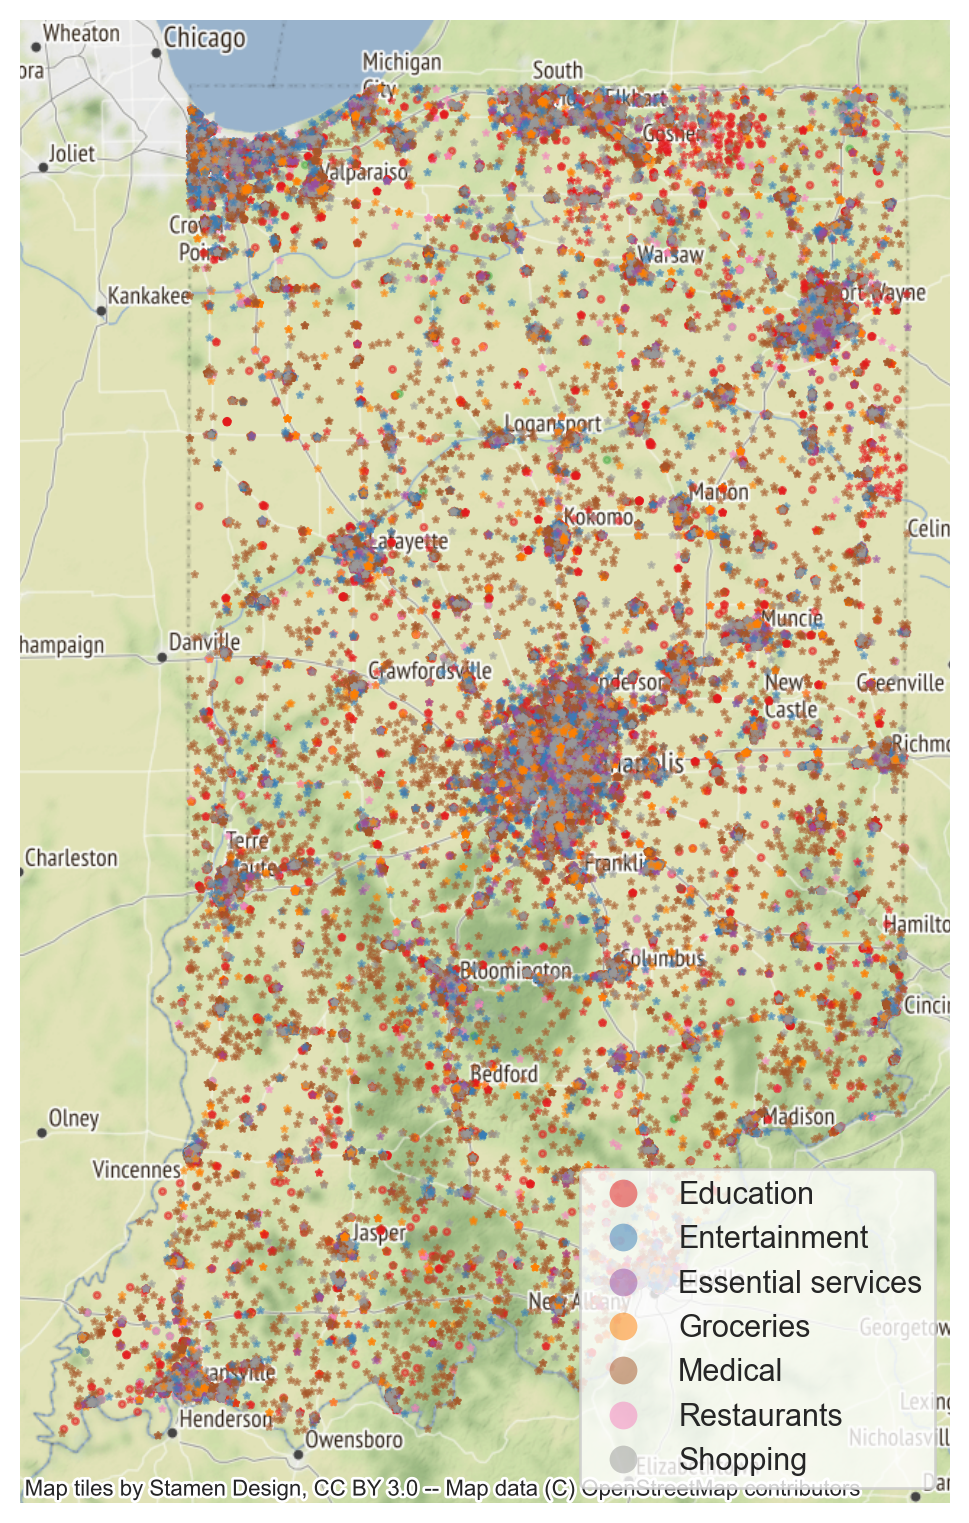

In [ ]:
ax = U.plot(axoff=1, size=(6, 12), dpi=200)
for src, marker in [('OSM', 'o'), ('SafeGraph', '*')]:
    pois.query(f'source=="{src}"').plot(
        ax=ax, column='category', marker=marker, cmap='Set1', legend=True, markersize=5, alpha=0.5)
ctx.add_basemap(ax=ax, crs=CRS_M)

# Miscellaneous

## LEHD/LODES

### Information

In [27]:
with open(P.data / 'lehd/columns.yaml', 'rb') as f:
    lehd_info = yaml.safe_load(f)

### Download data

In [28]:
def download_lehd_lodes(dataset='od', job_type='JT00', state='in', part='main',
                        segment='S000', year=2019, lodes_version=7,
                        aggregate_bg=False, save=True, overwrite=False):
    assert lodes_version in [6, 7]
    assert dataset in ['od', 'rac', 'wac']
    assert part in ['main', 'aux']
    assert job_type in [f'JT{i:02}' for i in range(6)]
    assert segment in 'S000 SA01 SA02 SA03 SE01 SE02 SE03 SI01 SI02 SI03'.split()
    outfile = P.data / f'lehd/lodes/{dataset}.parquet'
    if outfile.exists() and not overwrite:
        return
    root = f'https://lehd.ces.census.gov/data/lodes'
    fname = {'od': f'{state}_od_{part}_{job_type}_{year}',
             'rac': f'{state}_rac_{segment}_{job_type}_{year}',
             'wac': f'{state}_wac_{segment}_{job_type}_{year}'}[dataset]
    url = f'{root}/LODES{lodes_version}/{state}/{dataset}/{fname}.csv.gz'
    df = pd.read_csv(url).drop(columns='createdate', errors='ignore')
    idx_cols = {'od': ['h_geocode', 'w_geocode'],
                'rac': ['h_geocode'], 'wac': ['w_geocode']}[dataset]
    df = df.astype({col: str for col in idx_cols})
    if aggregate_bg:
        for col in idx_cols:
            df[col] = df[col].str.slice(0, 12)
        df = df.groupby(idx_cols).sum().reset_index()
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

download_lehd_lodes('od') # t=0:17
download_lehd_lodes('rac') # t=0:05
download_lehd_lodes('wac') # t=0:03

## Economic Tracker
GitHub: https://github.com/OpportunityInsights/EconomicTracker

In [29]:
def download_oi_ecotracker_data(overwrite=False):
    url = 'https://github.com/OpportunityInsights/EconomicTracker/archive/main.zip'
    outfile = P.data / 'economic_tracker/raw_data.zip'
    if outfile.exists() and not overwrite:
        return
    urllib.request.urlretrieve(url, U.mkfile(outfile))

# x = download_oi_ecotracker_data(); x # t=0:22